### Product Quality Assessment :
#### Classifying Products to Defected VS Not Defected (OK) based on their front image .
* **Dataset** : Kaggle Dataset : https://www.kaggle.com/ravirajsinh45/real-life-industrial-dataset-of-casting-product
* **Data** : The data contains 7348 grayscale images for a manufacturing product, 300x300 pixel images , augmentation results included 

## Project Methodology :
#### From Problem to Approach : Asking the right questions

- Business Understanding:  What is the Business Objective ?
    * The objective is to detect whether a manufactured product is defected or not  
- Use Case:
    * The production company wants to eliminate the defected products so the ones classifid as defected will not be sent to shipping .
    
- Understanding our ML Pipeline:
       * Input : 300 by 300 grayscale images with 1 color layer 
       * output : Classes of the Images , 0 as defected and 1 as Safe or OK
- Framing the Problem :
     * The problem here is an Image Classification task using a CNN
- Designing the System 
     * The Value of the output is 0 or 1 So the goal is to predict labels for images "Ok_front"  and "def_front'
     * We will be having a Binary classification Task 


In [ ]:
import tensorflow as tf

In [ ]:
#first thing to do is specify the metadata for processing images
color_mode = "grayscale"
num_color_layers = 1
img_size = (300,300)
img_shape = img_size +(num_color_layers,)
num_color_layers

1

## **Getting Image Data and creating training, test and validation set**
    * Our Data is inside directories and subdirectories, 
    * we will need to get the data with its labels from these directories .
    * we will be using the preprocessing method image_dataset_from_directory 
    * This will return a tf.data.Dataset that yields batches of images from the subdirectories def_front and ok_front , together  with labels 0 and 1 (0 corresponding to def_front and 1 corresponding to ok_front).

    * Since we will be creating datasets for training, validation and testing, we will just create a function instead of using the method 3 times .


In [ ]:
#we specify the paths to data 

training_data_path =''
test_data_path = ''
#or mount from drive .

In [ ]:
""" Seed helps get predictable, repeatable results every time.
    If we do not set the seed, then we get different random numbers at every invocation.
    Any number is fine but We use the number 42 commonly because it has a story that's all
"""
SEED=42

In [ ]:
# we will create a method that ingests data and prepares it :
def get_img_data(data_path, color_mode ,img_size ,seed=None,subset = None, validation_split = None):
    if subset :
        # we specify the validation size to be 20% of our data 
        validation_split = 0.2
    return tf.keras.preprocessing.image_dataset_from_directory(
        data_path,
        color_mode=color_mode,
        image_size=img_size,
        seed=seed,
        validation_split=validation_split,
        subset=subset
    )

In [ ]:
training_data = get_img_data(
    training_data_path,
    color_mode,
    img_size,
    SEED,
    subset = "training"
)
validation_data = get_img_data(
    training_data_path,
    color_mode,
    img_size,
    SEED,
    subset = "validation"
)
test_data = get_img_data(
    test_data_path,
    color_mode,
    img_size
)

Found 6633 files belonging to 2 classes.
Using 5307 files for training.
Found 6633 files belonging to 2 classes.
Using 1326 files for validation.
Found 6633 files belonging to 2 classes.


We will be having  :
* 5307 images for training 
* 1326 images for validation

In [ ]:
"""
a Batched Dataset is a dataset that can yield data only in batches.
"""
training_data

<BatchDataset shapes: ((None, 300, 300, 1), (None,)), types: (tf.float32, tf.int32)>

In [ ]:
"""
    * The OS module provides functions for interacting with the operating system.
    * listdir() method is used to get the list of all files and directories in the specified directory.
    * the join method combines one or more path names into a single path.
    * The image module supports basic image loading, rescaling and display operations.
"""
from os import listdir
from os.path import join
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
type(training_data)

tensorflow.python.data.ops.dataset_ops.BatchDataset

In [ ]:
# this is how our training data looks like
print(list(training_data.as_numpy_iterator()))

KeyboardInterrupt: 

In [ ]:
# class_names gives us the names of the classes in training_data 
print(training_data.class_names)
print(validation_data.class_names)

['def_front', 'ok_front']
['def_front', 'ok_front']


In [ ]:
# we perform a small sanity check of whether the classes in validation are the same in training
check =( training_data.class_names== validation_data.class_names)
assert_fail_message = "Training and Validation classes should match"
assert(check), assert_fail_message

# We are Good to go

## Vizualizing our images 

In [ ]:
# we obtain the labels of the existing classes and their number
class_names = training_data.class_names
number_classes = len(class_names)
print(class_names)

['def_front', 'ok_front']


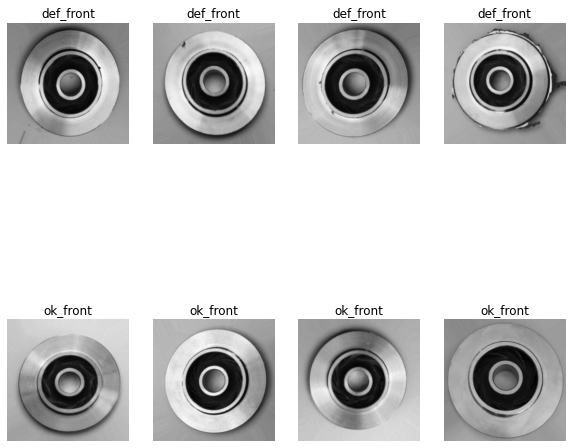

In [ ]:
# we can choose any images we want  we choose n=4 as number of images to preview per class
img_idx =[200,500,700,900]
# the imgs_file_paths is a dictionary having as keys the classes and the Images paths as values
imgs_file_paths = dict()
# we will loop through the classes and obtain for each class n=4 image paths
# we will store the paths inside imgs_file_paths dictionary 
for name in class_names:
    img_dir = join(training_data_path,name)
    imgs_fnames = listdir(img_dir)
    imgs_file_paths[name] = [join(img_dir,imgs_fnames[i]) for i in img_idx] 
imgs_file_paths


# plotting the images
plt.figure(figsize=(10,10))
for i,name in enumerate(class_names):
    for j,image in enumerate(imgs_file_paths[name]):
        image_number = (i * len(img_idx)) + j + 1
        ax = plt.subplot(number_classes,4,image_number)
        plt.title(name)
        plt.axis("off")
        plt.imshow(mpimg.imread(image))
        
        

## The 5-Step Model Life-Cycle

* The five steps in the life-cycle are as follows:

    * **Defining the model : Architecture**
        * Select the type of model that you need : 
            * Sequential Model in our case
        * Choose the architecture : 
            * Defining the layers of the model, configuring each layer with a number of nodes and activation function, and connecting the layers together. 
            * Here we chose 3 convolutional layers combined with maxpooling layers , one flatten layer and 2 dense layers and one dropout.
    * **Compile the model : Parameters**
        * First select a loss function that you want to optimize : 
            * we chose loss='binary_crossentropy'because we have a binary classifciation and this compares each of the predicted probabilities to actual class output which can be either 0 or 1.
            
        * Select an algorithm to perform the optimization procedure:
            * we choose optimizer='adam'because it's one of the best optimizers for classification.
            
        * Choose a Metric to call to evaluate predictions.
            * we choose the accuracy as a meaure of performance
    * **Fit the model: Here Happens the training process**
        * First select the training configuration, such as the number of epochs (loops through the training dataset) and the batch size (number of samples in an epoch used to estimate model error).
        * Training applies the chosen optimization algorithm to minimize the chosen loss function and updates the model using the backpropagation of error algorithm.
   
    * **Evaluate the model.**
        * first choose a holdout dataset used to evaluate the model(test_data in our case)
        * This involves calling a function with the holdout dataset and getting a training loss and accuracy,validation loss and accuracy and perhaps other metrics that can be reported depending on what we choose.
    * **Make predictions.**
        * you simply call a function to make a prediction of a class label, probability, or numerical value: whatever you designed your model to predict.

## Model Definition : Designing our Model

In [ ]:
#we will be rescaling our images to be in [0,1] range beacause the pixels are in[0,255]range
# and the Neural Network training values must be between [0,1]
#we will use the recaling tensorflow method and rescale with ration of 1./255

#Defining our Sequential Model
# We create a Sequential model by passing a list of layers to the Sequential constructor:
model = tf.keras.Sequential([
                tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=img_shape),
                tf.keras.layers.Conv2D(16,kernel_size=(3,3),dilation_rate=num_color_layers,padding='same',activation='relu'),
                tf.keras.layers.MaxPooling2D(),
                tf.keras.layers.Conv2D(32,kernel_size=(3,3),dilation_rate=num_color_layers,padding='same',activation='relu'),
                tf.keras.layers.MaxPooling2D(),
                tf.keras.layers.Conv2D(64,kernel_size=(3,3),dilation_rate=num_color_layers,padding='same',activation='relu'),
                tf.keras.layers.MaxPooling2D(),
                tf.keras.layers.Flatten(),
                tf.keras.layers.Dense(128, activation='relu'),
                tf.keras.layers.Dropout(0.5),
                tf.keras.layers.Dense(1,activation='sigmoid'),
])

## Information about our Sequential Model 
* How does it work :
    * Using tf.keras allows us to design, fit, evaluate, and use deep learning models to make predictions in just a few lines of code.
    
    * A Sequential model is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor.
     * Each layer has weights that correspond to the layer the follows it.
* what does each layer do :

    * Preprocessing Layers :
        * These layers are for standardizing the inputs of an image model, rescaling , resizing ...
    * Covolutional layers : 
        * Convo layer is sometimes called feature extractor layer because features of the image are extracted within this layer. 
        * First of all, a part of image is connected to Convo layer to perform convolution operation and calculating the dot product between receptive field(it is a local region of the input image that has the same size as that of filter) and the filter.
        * Result of the operation is single integer of the output volume.
        * Then we slide the filter over the next receptive field of the same input image by a Stride and do the same operation again.
        * We will repeat the same process again and again until we go through the whole image.
        * The output will be the input for the next layer. 
        * Convo layer also contains ReLU activation to make all negative value to zero.
    
    * Pooling Layers :
        * Pooling layer is used to reduce the spatial volume of input image after convolution. It is used between two convolution layer. If we apply **Fully Connected Layer** after Convo layer without applying pooling or max pooling, then it will be **computationally expensive** and we don’t want it. So, the pooling is only way to reduce the spatial volume of input image.
        * There is no parameter in pooling layer but it has two hyperparameters — Filter(F) and Stride(S).
    * Fully Connected Layer :
        * prediction is made in the fully connected layer
        * Fully connected layer involves weights, biases, and neurons.
        * It connects neurons in one layer to neurons in another layer.
        * It is used to classify images between different categories by training.
        * The input to the fully connected layer is the output from the final Pooling or Convolutional Layer, which is flattened and then fed into the fully connected layer.
        
    * Output layer:
        *  The output is whether or not an image belongs to a particular class, in this case it's binary
    
       

## Breaking down our model :
* We create a Sequential model by passing a list of layers to the Sequential constructor: 
    * tf.keras.Sequential([])

* We will be rescaling our images to be in [0,1] range beacause the pixels are in[0,255]range and the Neural Network training values must be between [0,1]

* We will use the recaling tensorflow method and rescale with ratio of 1./255
    * tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=img_shape),
  
* We start with the first Conv2D layer 
* The first required Conv2D parameter is the number of filters that the convolutional layer will learn:

    * tf.keras.layers.Conv2D(16, num_color_layers,padding='same',activation='relu')
        * First Parameter : Filters : the number of convolution filers used (a power of 2) 
        * The first required Conv2D parameter is the number of filters that the convolutional layer will learn.
        * Kernel Size which is usually 2 by 2 or 3 by 3 matrix  
        * Output volume size matches the input volume size by setting the padding value to the "same"
        * ACtivation : Convo layer contains ReLU activation to make all negative value to zero.
        
* Max pooling is then used to reduce the spatial dimensions of the output volume: 
    * tf.keras.layers.MaxPooling2D(),
        * it does not have parameters usually
    
* Why use 3 layers : 
    * we can choose the number of layers we want based on our needs , we can also try several ones.
    
         * tf.keras.layers.Conv2D(32, num_color_layers,padding='same',activation='relu'),
         * tf.keras.layers.MaxPooling2D(),
         * tf.keras.layers.Conv2D(64, num_color_layers,padding='same',activation='relu'),
         * tf.keras.layers.MaxPooling2D(),
         
* Flatten : We convert the output of the last layer into a 1-dimensional array for inputting it to the next layer.
    * We flatten the output of the convolutional layers to create a single long feature vector. And it is connected to the final classification model, which is called a fully-connected layer.

        * tf.keras.layers.Flatten(),
                
* Dense : Dense Layer is simple layer of neurons in which each neuron receives input from all the neurons of previous layer, thus called as dense. Dense Layer is used to classify image based on output from convolutional layers.
            it has 128 neurons here
            
        * tf.keras.layers.Dense(128, activation='relu'),
        

* Dropout :      
    * Dropout is a technique used to prevent a model from overfitting. ... Dropout works by randomly setting the outgoing edges of hidden units (neurons that make up hidden layers) to 0 at each update of the training phase.
        * tf.keras.layers.Dropout(0.5),
* Last Dense : this is the layer that outputs the classes .
     * tf.keras.layers.Dense(1,activation='sigmoid'),])
     
     
                
* **Remark** : Layers early in the network architecture that are closer to the actual input image learn fewer convolutional filters while layers deeper in the network closer to the output predictions will learn more filters.

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 300, 300, 1)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 300, 300, 16)      160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 150, 150, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 150, 150, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 37, 37, 64)        0

In [ ]:
# we will compile our model using adam ,binary cross entropy and accuracy as a performance measure.
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto',
    baseline=None, restore_best_weights=True
)
history = model.fit(
    training_data,
    validation_data = validation_data,
    epochs = 20,
    callbacks = [callback]
)

Epoch 1/20
166/166 [==============================] - 241s 1s/step - loss: 0.5389 - accuracy: 0.7192 - val_loss: 0.3923 - val_accuracy: 0.8763
Epoch 2/20
166/166 [==============================] - 286s 2s/step - loss: 0.2428 - accuracy: 0.8971 - val_loss: 0.1485 - val_accuracy: 0.9465
Epoch 3/20
166/166 [==============================] - 218s 1s/step - loss: 0.1193 - accuracy: 0.9567 - val_loss: 0.1109 - val_accuracy: 0.9691
Epoch 4/20
166/166 [==============================] - 221s 1s/step - loss: 0.1131 - accuracy: 0.9578 - val_loss: 0.0579 - val_accuracy: 0.9872
Epoch 5/20
166/166 [==============================] - 224s 1s/step - loss: 0.0416 - accuracy: 0.9887 - val_loss: 0.0449 - val_accuracy: 0.9879
Epoch 6/20
166/166 [==============================] - 225s 1s/step - loss: 0.0396 - accuracy: 0.9872 - val_loss: 0.0376 - val_accuracy: 0.9940
Epoch 7/20
166/166 [==============================] - 224s 1s/step - loss: 0.0332 - accuracy: 0.9904 - val_loss: 0.0741 - val_accuracy: 0.9774

* **Callbacks** :
    * A callback is a set of functions to be applied at given stages of the training procedure e.g. at the start or end of an epoch, before or after a single batch, etc).. You can use callbacks to get a view on internal states and statistics of the model during training.
    
    * You define and use a callback when you want to automate some tasks after every training/epoch that help you have controls over the training process. This includes stopping training when you reach a certain accuracy/loss score, saving your model as a checkpoint after each successful epoch, adjusting the learning rates over time, and more. Let’s dive deep into some callback functions!
    
        * **early stopping** : Stop training when a monitored metric has stopped improving.
* **model.fit** :
    * After the model is created, and configured with losses and metrics with model.compile(), 
    we train the model with model.fit(), 
    * after training using the fit method , we can use the model to do prediction with model.predict().

 

In [ ]:
model.evaluate(test_data)

208/208 [==============================] - 67s 321ms/step - loss: 0.0221 - accuracy: 0.9967


[0.02209426835179329, 0.9966832399368286]

#### how does evaluate work
    * Model evaluation aims to estimate the generalization accuracy of a model on future (unseen/out-of-sample) data

 * **Measuring Performance**
     * we will be using the accuracy curves

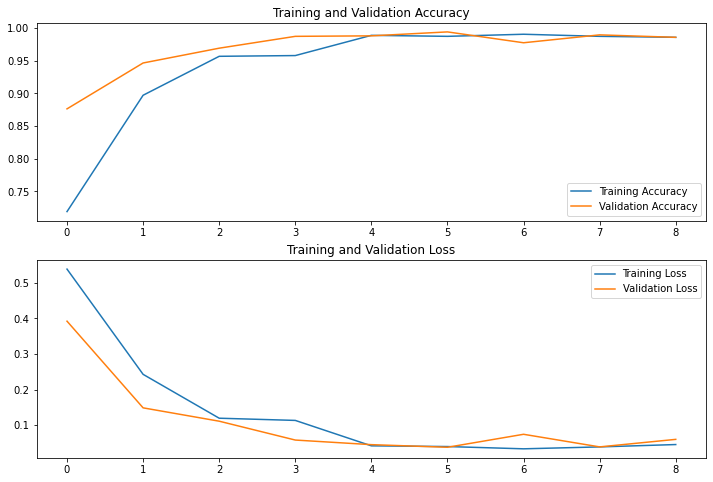

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(2, 1, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Saving the model 

In [ ]:
# this will save your model into the end directory of the path you choose
model.save('path')

INFO:tensorflow:Assets written to: path\assets
